# `009-linreg-learner`

Task: Fit a linear regression by gradient descent.

## Setup

In [1]:
from fastai.vision.all import *

This function will make a `DataLoaders` object out of an arary dataset.

In [2]:
def make_dataloaders(x, y_true, splitter, batch_size):
    data = L(zip(x, y_true))
    train_indices, valid_indices = splitter(data)
    return DataLoaders(
        DataLoader(data[train_indices], batch_size=batch_size, shuffle=True),
        DataLoader(data[valid_indices], batch_size=batch_size)
    )   

Here are utility functions to plot the first axis of a dataset and a model's predictions.

In [3]:
def plot_data(x, y): plt.scatter(x[:, 0], y[:, 0], s=1)
def plot_model(x, model):
    x = torch.sort(x)[0]
    y_pred = model(x).detach()
    plt.plot(x[:, 0], y_pred[:, 0], 'r')

## Task

Remember this? Suppose we have a dataset with just a single feature `x` and continuous outcome variable `y`.

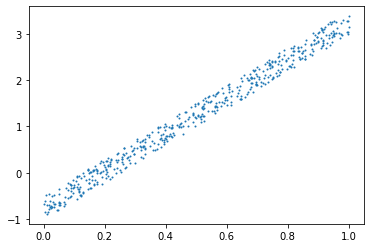

In [4]:
torch.manual_seed(0)
x = torch.rand(500, 1)
noise = torch.rand_like(x) * .5
y_true = 4 * x - 1 + noise

plot_data(x, y_true)
plt.xlabel('x (features)'); plt.ylabel('y (outputs or target)');

Let's fit a line to that!

In notebook `006` we manually wrote out `y_pred = weights * x + bias`, and manually took a step that reduced the mean squared error `mse_loss = (y_pred - y_true).pow(2).mean()`. In this notebook, we'll use `nn.Linear` and fastai's `Learner` class.

First we'll make a fastai-compatible `DataLoaders` from this dataset. You should know everything you need to understand how this works, but don't worry about it on the first time around.

In [5]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)
batch_size = 5
dataloaders = make_dataloaders(x, y_true, splitter, batch_size=batch_size)

## Solution

Use the `one_batch` method to inspect one batch of the `train` dataloader. Be sure that you can explain the shapes of everything you see. (Look above to see the `batch_size` that this dataloader uses.)

In [6]:
# batch = ...
batch = dataloaders.train.one_batch()
# X_batch = batch... # get the features
X_batch = batch[0] # get the features
# y_batch = batch... # get the labels
y_batch = batch[1] # get the labels
X_batch

tensor([[0.5537],
        [0.9515],
        [0.2867],
        [0.5460],
        [0.2820]])

In [7]:
y_batch

tensor([[1.6838],
        [3.0121],
        [0.5860],
        [1.5365],
        [0.2060]])

**Fill in the blanks to construct a `model`**:

```
model = nn.Linear(in_features=..., out_features=..., bias=...)
```

* For `in_features`, think about the shape of the input data.
* For `out_features`, think about the shape of the output data.

In [8]:
# model = nn.Linear(in_features=..., out_features=..., bias=...)
model = nn.Linear(in_features=1, out_features=1, bias=True)

To check that we got it right, **call the `model` with the input data from the example batch**.

In [9]:
# y_pred = ...
y_pred = model(X_batch)
y_pred

tensor([[-0.0974],
        [-0.2897],
        [ 0.0315],
        [-0.0937],
        [ 0.0338]], grad_fn=<AddmmBackward>)

Let's look at what the model currently predicts on all the data.

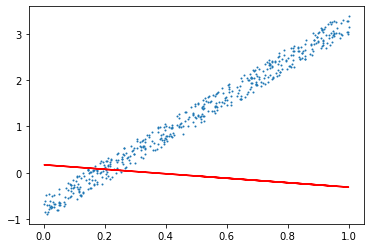

In [10]:
plot_data(x, y_true)
plot_model(x, model)

Pretty bad, huh? Let's evaluate the error on the batch we got:

In [11]:
mse_loss = (y_pred - y_batch).pow(2).mean()
mse_loss

tensor(3.4138, grad_fn=<MeanBackward0>)

**Create a `loss_func` by instantiating an `nn.MSELoss`.**

In [12]:
# loss_func = ...
loss_func = nn.MSELoss()

**Evaluate the loss on the  `loss_func` on the example batch.**  Check that the output matches exactly.

Note: PyTorch loss functions take inputs, then targets. `sklearn` loss functions (metrics) use the reverse order.

In [13]:
# ...
loss_func(y_pred, y_batch)

tensor(3.4138, grad_fn=<MseLossBackward>)

**Construct a `Learner`.**

* Use the `dataloaders`, `model`, and `loss_func` constructed above.
* Use `SGD` as the `opt_func`.
* The default `metric` is fine so you can omit it. (If you want to, you may add Mean Absolute Error (`mae`).)

In [14]:
# ... <<<EOF
learner = Learner(
    dls=dataloaders,
    model=model,
    loss_func=loss_func,
    opt_func=SGD,
    metrics=[mae]
)
# EOF

**Fit the Learner for 10 epochs at the default learning rate.**

Plot the loss when it's finished.

epoch,train_loss,valid_loss,mae,time
0,0.454568,0.183978,0.359513,00:00
1,0.133444,0.042771,0.169272,00:00
2,0.046238,0.028243,0.145732,00:00
3,0.026476,0.024858,0.136927,00:00
4,0.022421,0.024556,0.136127,00:00
5,0.022210,0.024813,0.136876,00:00
6,0.021226,0.025875,0.139478,00:00
7,0.021760,0.024306,0.135403,00:00
8,0.021764,0.024181,0.134982,00:00
9,0.021933,0.024390,0.135658,00:00


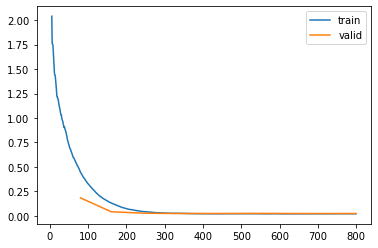

In [15]:
# ...
learner.fit(n_epoch=10, lr=1e-1)
learner.recorder.plot_loss()

**Now let's look at what the model predicts.**

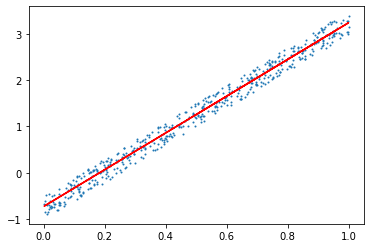

In [16]:
plot_data(x, y_true)
plot_model(x, model)

**Not there yet! Try different learning rates in the `learner.fit` to see if you can get it to train to convergence in 10 epochs.**

Remember to Restart and Run All to check that you're starting with a clean model.

## Analysis

Inspect the `weight` and `bias` attributes of `model`. How close are they to the ideal values? Explain.

In [17]:
# ...
print(model.weight)

Parameter containing:
tensor([[3.9724]], requires_grad=True)


In [18]:
# ...
print(model.bias)

Parameter containing:
tensor([-0.7291], requires_grad=True)


## Extension (optional)

Suppose we rerun this notebook hundreds of times with different random seeds. What is the expected value of the validation loss? 

Answer this by looking at the way that `y_true` was constructed.

(Assume that the model gets enough training data that `weights` and `bias` get exactly the right values. It turns out that this assumption isn't actually needed, but it will make it easier to think about where the error comes from.)

In [29]:
noise.std()**2

tensor(0.0216)

In [28]:
noise.var()

tensor(0.0216)

(array([50., 45., 51., 51., 46., 55., 53., 40., 48., 61.]),
 array([3.9845705e-05, 4.9994372e-02, 9.9948898e-02, 1.4990343e-01,
        1.9985795e-01, 2.4981248e-01, 2.9976702e-01, 3.4972155e-01,
        3.9967605e-01, 4.4963059e-01, 4.9958512e-01], dtype=float32),
 <BarContainer object of 10 artists>)

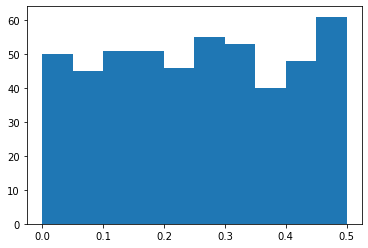

In [34]:
plt.hist(noise[:,0].numpy())

In [36]:
.25/12

0.020833333333333332

In [29]:
noise.std()**2

tensor(0.0216)

In [28]:
noise.var()

tensor(0.0216)

(array([50., 45., 51., 51., 46., 55., 53., 40., 48., 61.]),
 array([3.9845705e-05, 4.9994372e-02, 9.9948898e-02, 1.4990343e-01,
        1.9985795e-01, 2.4981248e-01, 2.9976702e-01, 3.4972155e-01,
        3.9967605e-01, 4.4963059e-01, 4.9958512e-01], dtype=float32),
 <BarContainer object of 10 artists>)

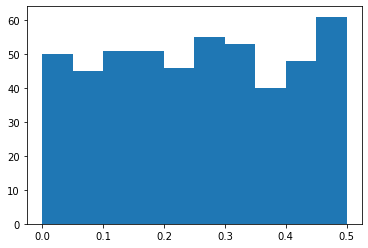

In [34]:
plt.hist(noise[:,0].numpy())

In [36]:
.25/12

0.020833333333333332